In [1]:
from MCEq.core import MCEqRun
import crflux.models as crf
import MCEq.config as config
from MCEq.geometry.density_profiles import MSIS00Atmosphere
from MCEq.geometry.geometry import EarthGeometry
config.kernel_config= 'MKL'
config.e_min = 0.160
config.integrator= 'euler'
import numpy as np
import crflux.models as pm
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

# Initalize MCEq by creating the user interface object MCEqRun
# Initialize custom atmosphere model with coordinates
# Note: Using custom location with latitude/longitude parameters
mag = 0
# Initialize MCEq with custom atmosphere and Frisco Peak location
mceq = MCEqRun(
    # interaction interaction model
    interaction_model='SIBYLL23C',
    # Primary cosmic ray model
    primary_model=(pm.GlobalSplineFitBeta, None),
    # Set to 0° for horizontal muons
    theta_deg=0.,
    # Use custom atmosphere and geometry
    density_model=("CORSIKA", ('USStd', None)),
    #density_model=("MSIS00_IC", ('FriscoPeak', 'January')),
)
#mceq.set_density_model(("CORSIKA", ('USStd', None)))
earth_geom = EarthGeometry()

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta 


In [158]:
def get_spectrum(theta, Nh, mag=1):
    mceq.set_theta_deg(theta)
    mceq.integration_path = None 
    angle_rad = np.radians(theta)
    L = earth_geom.path_len(angle_rad)
    
    # l_grid goes L -> 0 (Bottom to Top)
    L_grid = np.linspace(L, 0, Nh) 
    
    # h_grid goes h(0) -> h(L) which is TOP to BOTTOM (e.g., 100km -> 0km)
    H_grid = np.array([earth_geom.h(l, angle_rad) for l in (L) - L_grid])
    # X_grid goes X(Top) -> X(Bottom) which is 0 -> 1030 (Correct for solver)
    X_grid = mceq.density_model.h2X(H_grid)
    print(len(L_grid), len(H_grid), len(X_grid))
    mceq.solve(int_grid=X_grid)
    
    longitudinal_spectrum = [
        mceq.get_solution('total_mu-', grid_idx=idx, mag=mag)
        for idx in range(len(X_grid))]
    CDF = np.array(longitudinal_spectrum)
    # dPhidX is [Positive] (Flux increases with depth)
    dPhidX = np.gradient(CDF, X_grid, axis=0)
    dPhidX = np.clip(dPhidX, 0, None)  # Remove negative values
    # dXdh is [Negative] (As h increases, X decreases) use -dXdh to get positive production rate per km
    dXdh = -np.gradient(X_grid, H_grid)
    dPhidh = dPhidX * dXdh[:, None]
    
    # VERIFICATION: Does the sum of production = Ground Flux?
    # Integration over X
    total_produced_X = np.sum(dPhidX * np.abs(np.gradient(X_grid))[:, None], axis=0)
    # Integration over h
    total_produced_h = np.sum(dPhidh * np.abs(np.gradient(H_grid))[:, None], axis=0)
    
    # Compare ground values (integrating over E_grid for a single scalar number)
    sum_mceq = np.trapezoid(CDF[-1, :], mceq.e_grid)
    sum_prod_X = np.trapezoid(total_produced_X, mceq.e_grid)
    sum_prod_h = np.trapezoid(total_produced_h, mceq.e_grid)
    
    print(f"--- Consistency Check (Theta={theta}) ---")
    print(f"MCEq Flux at Ground:        {sum_mceq:.2e}")
    print(f"Integrated Prod (dX):       {sum_prod_X:.2e}")
    print(f"Integrated Prod (dh):       {sum_prod_h:.2e}")
    print(f"Error X:                      {abs(sum_mceq-sum_prod_X)/sum_mceq:.2%}")
    print(f"Error h:                      {abs(sum_mceq-sum_prod_h)/sum_mceq:.2%}")
    return dPhidX,dPhidh, CDF, L_grid, X_grid, H_grid

dPhidX, dPhidh, CDF, L_grid, X_grid, H_grid = get_spectrum(0, 1000)


1000 1000 1000
--- Consistency Check (Theta=0) ---
MCEq Flux at Ground:        3.73e-04
Integrated Prod (dX):       3.76e-04
Integrated Prod (dh):       3.76e-04
Error X:                      0.84%
Error h:                      0.84%


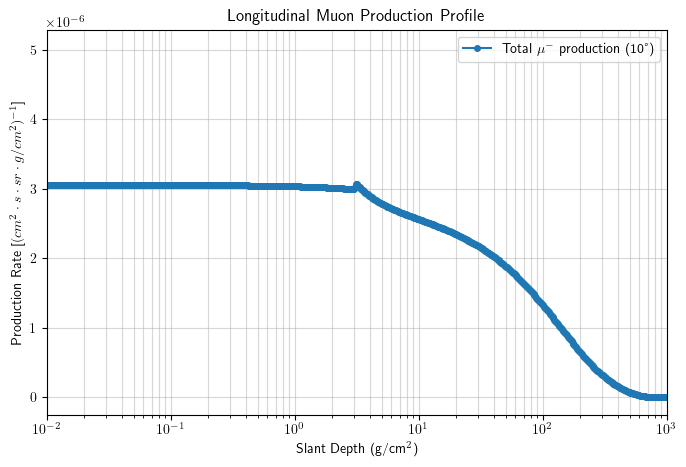

In [159]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Physical Integral over Energy (Important for Log-Grids!)
# This converts dPhidh [cm^-2 s^-1 sr^-1 km^-1 GeV^-1] 
# to Total Production [cm^-2 s^-1 sr^-1 km^-1]
E = mceq.e_grid
production_per_X = np.trapezoid(dPhidX, E, axis=1)

# 2. Convert Altitude to km (Assuming H_grid is in cm)
# If earth_geom.h returns cm, 1e5 is correct.
x_data_km = X_grid

plt.figure(figsize=(8, 5))
plt.plot(x_data_km, production_per_X, "o-", markersize=4, label=f'Total $\mu^-$ production (10°)')

# 3. Aesthetics matching Garg et al.
#plt.yscale("symlog") # Production varies by orders of magnitude
plt.xscale("log") # Slant depth often plotted on log scale
plt.xlim(1e-2, 1e3) # Focus on relevant slant depth range
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.xlabel("Slant Depth (g/cm$^2$)")
plt.ylabel(r"Production Rate [$(cm^{2} \cdot s \cdot sr \cdot g/cm^2)^{-1}$]")
plt.title("Longitudinal Muon Production Profile")
plt.legend()

plt.show()


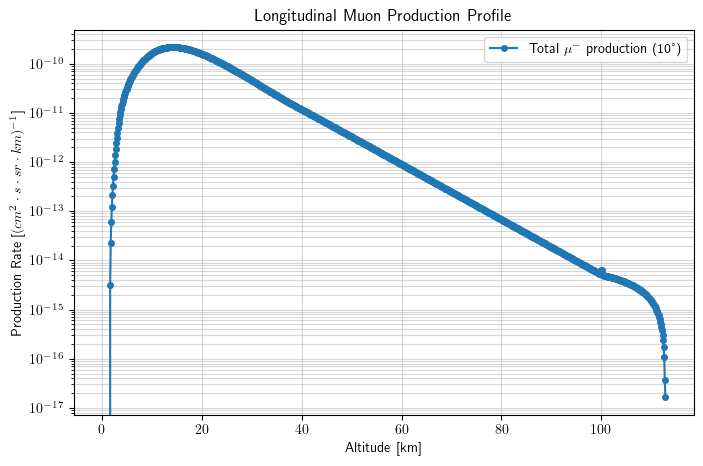

In [160]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Physical Integral over Energy (Important for Log-Grids!)
# This converts dPhidh [cm^-2 s^-1 sr^-1 km^-1 GeV^-1] 
# to Total Production [cm^-2 s^-1 sr^-1 km^-1]
E = mceq.e_grid
production_per_km = np.trapezoid(dPhidh, E, axis=1)

# 2. Convert Altitude to km (Assuming H_grid is in cm)
# If earth_geom.h returns cm, 1e5 is correct.
x_data_km = H_grid / 1e5 

plt.figure(figsize=(8, 5))
plt.plot(x_data_km, production_per_km, "o-", markersize=4, label=f'Total $\mu^-$ production (10°)')

# 3. Aesthetics matching Garg et al.
plt.yscale("log") # Production varies by orders of magnitude
#plt.xscale("log") # Altitude often plotted on log scale
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.xlabel("Altitude [km]")
plt.ylabel(r"Production Rate [$(cm^{2} \cdot s \cdot sr \cdot km)^{-1}$]")
plt.title("Longitudinal Muon Production Profile")
plt.legend()

plt.show()


In [3]:
import numpy as np
def get_spectrum(theta, Nh, mag=1):
    mceq.set_theta_deg(theta)
    mceq.integration_path = None 
    angle_rad = np.radians(theta)
    L = earth_geom.path_len(angle_rad)
    
    # l_grid goes L -> 0 (Bottom to Top)
    L_grid = np.linspace(L, 0, Nh) 
    
    # h_grid goes h(0) -> h(L) which is TOP to BOTTOM (e.g., 100km -> 0km)
    H_grid = np.array([earth_geom.h(l, angle_rad) for l in (L) - L_grid])
    # X_grid goes X(Top) -> X(Bottom) which is 0 -> 1030 (Correct for solver)
    X_grid = mceq.density_model.h2X(H_grid)
    mceq.solve(int_grid=X_grid)
    
    longitudinal_spectrum = [
        mceq.get_solution('total_mu-', grid_idx=idx, mag=mag) + mceq.get_solution('total_mu+', grid_idx=idx, mag=mag)
        for idx in range(len(X_grid))]
    CDF = np.array(longitudinal_spectrum)
    # dPhidX is [Positive] (Flux increases with depth)
    dPhidX = np.gradient(CDF, X_grid, axis=0)
    dPhidX = np.clip(dPhidX, 0, None)  # Remove negative values
    # dXdh is [Negative] (As h increases, X decreases) use -dXdh to get positive production rate per km
    dXdh = -np.gradient(X_grid, H_grid)
    dPhidh = dPhidX * dXdh[:, None]
    return dPhidh, L_grid, X_grid, H_grid
def solid_angle(zenith, d_theta, d_phi):
    return (np.cos(np.radians(zenith))-np.cos(np.radians(zenith)+d_theta)) * d_phi
# Assuming you already have: zenith_angles, E0, threshold, get_spectrum(...), etc.
zenith_angles = np.linspace(0, 90, 5)  # Your zenith range
Nh = 10  # Number of height bins
E0 = mceq.e_grid  # Energy grid from MCEq
E_mag_min = np.log10(10000)
E_mag_max = 6
threshold_min = 10**E_mag_min
threshold_max = 10**E_mag_max

Area =  0.87890625# Define the area of the detector in cm^2
d_theta = np.radians(np.diff(zenith_angles).min())  # Assuming uniform spacing in zenith angles
d_phi = np.radians(180) - np.radians(0) # Full azimuthal coverage (0 to 180 degrees)


E = E0[(E0 >= threshold_min) & (E0 <= threshold_max)]          # shape (NE,)
Nz = len(zenith_angles)  # Number of zenith bins
NE = len(E)  # Number of energy bins
print("Dimension of data (Nz, NE, Nh):", Nz, NE, Nh)
H_grids = []              # per-zenith h grids, shape -> (Nz, Nh)
dPhidh_dE_zenith = []
N_mu_dE = 0
for zenith in zenith_angles:
    dPhidh, l_grid, X_grid, h_grid = get_spectrum(zenith, Nh)   # m shape: (Nh, len(E0))
    H_grids.append(h_grid)
    dh = np.gradient(h_grid) # shape (Nh,)
    dPhidh = dPhidh #* solid_angle(zenith, d_theta, d_phi) * Area                     # still shape (Nh, len(E0))
    dPhidh = dPhidh[:, (E0 >= threshold_min) & (E0 <= threshold_max)]                  # -> (Nh, NE)
    #muon count:
    dPhidE = np.sum(dPhidh * np.abs(np.gradient(h_grid))[:, None], axis=0)
    N_mu_dE += dPhidE * solid_angle(zenith, d_theta, d_phi) * Area
    print(solid_angle(zenith, d_theta, d_phi), zenith, d_theta, d_phi)
    dPhidh_dE_zenith.append(dPhidh)                                   

dPhidh_dE = np.array(dPhidh_dE_zenith)  # shape (Nz, Nh, NE)
N_mu = np.trapezoid(dPhidE, E, axis=0)
print(f"Total muon count per second (N_mu): {N_mu}")
#dPhidh_dE = dPhidh_dE/np.sum(dPhidh_dE)

Dimension of data (Nz, NE, Nh): 5 20 10
0.23913950145036228 0.0 0.39269908169872414 3.141592653589793
0.6810116830602476 22.5 0.39269908169872414 3.141592653589793
1.0192060093104904 45.0 0.39269908169872414 3.141592653589793
1.2022354597686926 67.5 0.39269908169872414 3.141592653589793
1.2022354597686926 90.0 0.39269908169872414 3.141592653589793
Total muon count per second (N_mu): 4.2512335270549444e-05


In [11]:
import numpy as np

def get_ground_flux(theta, mag=1):
    """Get muon flux at ground level for a given zenith angle."""
    mceq.set_theta_deg(theta)
    mceq.solve()
    # Flux at the lowest observation level (ground), shape: (NE_full,)
    flux = (mceq.get_solution('total_mu-', mag=mag) +
            mceq.get_solution('total_mu+', mag=mag))
    return flux


def get_longitudinal(theta, Nh=500, mag=1):
    """Get longitudinal muon flux profile (if you still need production info)."""
    mceq.set_theta_deg(theta)
    mceq.integration_path = None
    angle_rad = np.radians(theta)
    L = earth_geom.path_len(angle_rad)

    L_grid = np.linspace(L, 0, Nh)
    H_grid = np.array([earth_geom.h(l, angle_rad) for l in (L - L_grid)])
    X_grid = mceq.density_model.h2X(H_grid)
    mceq.solve(int_grid=X_grid)

    longitudinal_spectrum = np.array([
        mceq.get_solution('total_mu-', grid_idx=idx, mag=mag) +
        mceq.get_solution('total_mu+', grid_idx=idx, mag=mag)
        for idx in range(len(X_grid))])

    return longitudinal_spectrum, L_grid, X_grid, H_grid


# ── Configuration ──────────────────────────────────────────────────────
zenith_angles = np.linspace(0, 85, 18)  # avoid 90° (horizontal divergence)
E0 = mceq.e_grid                         # full MCEq energy grid

E_mag_min = np.log10(10000)               # 10 TeV
E_mag_max = 6                             # 1 PeV
threshold_min = 10**E_mag_min
threshold_max = 10**E_mag_max

Area = 0.87890625                         # detector area [cm²]
d_phi = np.pi                             # azimuthal coverage [rad] (0 to 180°)

# Energy mask
e_mask = (E0 >= threshold_min) & (E0 <= threshold_max)
E = E0[e_mask]                            # shape (NE,)
NE = len(E)
Nz = len(zenith_angles)

print(f"Dimension of data (Nz, NE): {Nz}, {NE}")

# ── Compute rate ───────────────────────────────────────────────────────
# From Eq. 3.2 of the muon background paper:
#   Γ_μ = ∫ Φ_μ(E,θ) · A_eff(E,θ) · cos(θ) · sin(θ) dθ dφ dE
#
# For a flat horizontal detector: A_eff = A_geom · cos(θ)  (projected area)
# But the cos(θ) from solid-angle projection is already in the integrand,
# so for a flat detector the effective integrand is:
#   Φ(E,θ) · A · cos(θ) · sin(θ) dθ dφ dE

d_theta = np.radians(np.diff(zenith_angles).mean())  # uniform bin width [rad]

# Differential rate dΓ/dE accumulated over zenith bins
dRate_dE = np.zeros(NE)
flux_vs_zenith = np.zeros((Nz, NE))

for iz, zenith in enumerate(zenith_angles):
    # Ground-level differential muon flux Φ(E) [1/(cm² s sr GeV)]
    flux_full = get_ground_flux(zenith, mag=1)
    flux = flux_full[e_mask]                          # shape (NE,)
    flux_vs_zenith[iz, :] = flux

    theta_rad = np.radians(zenith)

    # Solid angle element for this zenith bin: sin(θ) dθ dφ
    dOmega = np.sin(theta_rad) * d_theta * d_phi

    # Geometric projection for flat horizontal detector: cos(θ)
    cos_proj = np.cos(theta_rad)

    # Accumulate:  Φ(E,θ) · A · cos(θ) · dΩ   [units: 1/(s GeV)]
    dRate_dE += flux * Area * cos_proj * dOmega

    print(f"  θ={zenith:5.1f}°  dΩ={dOmega:.4e}  cos={cos_proj:.4f}")

# Integrate over energy to get total rate [1/s]
N_mu = np.trapezoid(dRate_dE, E)
print(f"\nTotal muon rate: {N_mu:.6e} s⁻¹")
print(f"Total muon rate: {N_mu * 3600:.6e} hr⁻¹")


Dimension of data (Nz, NE): 18, 20
  θ=  0.0°  dΩ=0.0000e+00  cos=1.0000
  θ=  5.0°  dΩ=2.3894e-02  cos=0.9962
  θ= 10.0°  dΩ=4.7607e-02  cos=0.9848
  θ= 15.0°  dΩ=7.0957e-02  cos=0.9659
  θ= 20.0°  dΩ=9.3767e-02  cos=0.9397
  θ= 25.0°  dΩ=1.1586e-01  cos=0.9063
  θ= 30.0°  dΩ=1.3708e-01  cos=0.8660
  θ= 35.0°  dΩ=1.5725e-01  cos=0.8192
  θ= 40.0°  dΩ=1.7622e-01  cos=0.7660
  θ= 45.0°  dΩ=1.9386e-01  cos=0.7071
  θ= 50.0°  dΩ=2.1002e-01  cos=0.6428
  θ= 55.0°  dΩ=2.2458e-01  cos=0.5736
  θ= 60.0°  dΩ=2.3743e-01  cos=0.5000
  θ= 65.0°  dΩ=2.4847e-01  cos=0.4226
  θ= 70.0°  dΩ=2.5762e-01  cos=0.3420
  θ= 75.0°  dΩ=2.6481e-01  cos=0.2588
  θ= 80.0°  dΩ=2.6999e-01  cos=0.1736
  θ= 85.0°  dΩ=2.7311e-01  cos=0.0872

Total muon rate: 3.168680e-06 s⁻¹
Total muon rate: 1.140725e-02 hr⁻¹


In [12]:
# Test 1: Vertical muon flux at sea level, E > 10 GeV
mceq.set_theta_deg(0.)
mceq.solve()

e_mask = mceq.e_grid >= 10.0  # E > 10 GeV
E = mceq.e_grid[e_mask]

flux_mu = (mceq.get_solution('total_mu+', mag=1) +
           mceq.get_solution('total_mu-', mag=1))
flux_mu = flux_mu[e_mask]

# Integrate over energy: ∫ Φ(E) dE
vertical_flux = np.trapezoid(flux_mu, E)
print(f"Vertical muon flux (E>10 GeV): {vertical_flux:.4f} cm⁻² s⁻¹ sr⁻¹")

# The paper's 0.0738 is integrated over solid angle for zenith-pointing.
# For a zenith-pointing camera, they integrate over angles near vertical.
# Compare the per-steradian flux first as a sanity check.
# Known value: ~0.01 cm⁻² s⁻¹ sr⁻¹ for vertical E>1 GeV (PDG)


Vertical muon flux (E>10 GeV): 0.0139 cm⁻² s⁻¹ sr⁻¹


In [15]:
# Reproduce Trinity Table 2: zenith-pointing, H0=0 km, E>10 GeV
# Zenith-pointing means the detector normal points UP
# Muons arrive from all zenith angles within the FOV
# For a camera, FOV is limited, but Table 2 seems to use full hemisphere

zenith_angles_test = np.linspace(0, 89, 45)  # fine angular grid
d_theta = np.radians(np.diff(zenith_angles_test).mean())
d_phi = 2 * np.pi  # full azimuth

e_mask = mceq.e_grid >= 10.0
E = mceq.e_grid[e_mask]

total_flux = 0.0
flux_per_angle = []

for theta in zenith_angles_test:
    mceq.set_theta_deg(theta)
    mceq.solve()
    flux = (mceq.get_solution('total_mu+', mag=1) +
            mceq.get_solution('total_mu-', mag=1))[e_mask]
    
    # Integrate over energy
    flux_E_integrated = np.trapezoid(flux, E)  # cm⁻² s⁻¹ sr⁻¹
    
    theta_rad = np.radians(theta)
    # Solid angle element × cos(θ) projection for zenith-pointing flat detector
    dOmega = np.sin(theta_rad) * d_theta * d_phi
    
    total_flux += flux_E_integrated * np.cos(theta_rad) * dOmega
    flux_per_angle.append(flux_E_integrated)
    
print(f"Integrated muon flux (zenith-pointing, E>10 GeV): {total_flux:.4f} cm⁻² s⁻¹")
print(f"Trinity Table 2 value:                            0.0738 cm⁻² s⁻¹")


Integrated muon flux (zenith-pointing, E>10 GeV): 0.0376 cm⁻² s⁻¹
Trinity Table 2 value:                            0.0738 cm⁻² s⁻¹


In [16]:
# Try without cos(θ) projection — just solid angle integration
total_flux_no_proj = 0.0
for iz, theta in enumerate(zenith_angles_test):
    theta_rad = np.radians(theta)
    dOmega = np.sin(theta_rad) * d_theta * d_phi
    total_flux_no_proj += flux_per_angle[iz] * dOmega

print(f"Without cos projection: {total_flux_no_proj:.4f} cm⁻² s⁻¹")
print(f"With cos projection:    {total_flux:.4f} cm⁻² s⁻¹")
print(f"Trinity Table 2:        0.0738 cm⁻² s⁻¹")


Without cos projection: 0.0629 cm⁻² s⁻¹
With cos projection:    0.0376 cm⁻² s⁻¹
Trinity Table 2:        0.0738 cm⁻² s⁻¹


In [ ]:
import numpy as np

def save_muon_spectrum_data(dF_dE_zenith, E, zenith_angles, H_grids, E_mag_min, height_threshold=294400):
    """
    Save muon spectrum data to a text file in the specified format.
    
    Parameters:
    - dF_dE_zenith: array of shape (Nz, Nh, NE) containing the differential flux
    - E: energy grid array of shape (NE,)
    - zenith_angles: array of zenith angles of shape (Nz,)
    - H_grids: list of height grids, each of shape (Nh,)
    - E_mag_min: minimum energy magnitude for filename
    - height_threshold: minimum height threshold in cm
    """
    
    # Get dimensions
    Nz, Nh, NE = dN_dE_zenith.shape
    
    # Create coordinate meshgrids
    energies_full = []
    heights_full = []
    zeniths_full = []
    weights_full = []
    
    for z_idx in range(Nz):
        for h_idx in range(Nh):
            for e_idx in range(NE):
                energies_full.append(E[e_idx])
                heights_full.append(H_grids[z_idx][h_idx])
                zeniths_full.append(zenith_angles[z_idx])
                weights_full.append(dN_dE_zenith[z_idx, h_idx, e_idx])
    
    # Convert to numpy arrays
    energies_full = np.array(energies_full)
    heights_full = np.array(heights_full)
    zeniths_full = np.array(zeniths_full)
    weights_full = np.array(weights_full)
    
    # Apply height mask
    mask = heights_full >= height_threshold
    
    # Filter data based on mask
    energies_filtered = energies_full[mask]
    heights_filtered = heights_full[mask]
    zeniths_filtered = zeniths_full[mask]
    weights_filtered = weights_full[mask]
    
    # Count valid samples
    n_samples = len(energies_filtered)
    
    # Create output filename
    output_filename = f"/uufs/chpc.utah.edu/common/home/u1520754/Muon_Trinity/data/sampled_muon_parameters_1E{E_mag_min}_N{n_samples}.txt"
    
    # Create the output array
    output_data = np.column_stack((energies_filtered, heights_filtered, zeniths_filtered, weights_filtered))
    
    # Save with header and formatting
    header = "Energy(GeV) Height(cm) Zenith(deg) Weights"
    np.savetxt(output_filename, output_data, 
               fmt=['%.6e', '%.6e', '%.6f', '%.6e'],
               header=header,
               comments='# ')
    
    print(f"Saved {n_samples} samples to {output_filename}")
    return output_filename

# Example usage with your existing variables:
# Assuming you have: dPhidh_dE, E, zenith_angles, H_grids, E_mag_min defined
output_file = save_muon_spectrum_data(dPhidh_dE_zenith, E, zenith_angles, H_grids, E_mag_min)


Saved 6240 samples to /uufs/chpc.utah.edu/common/home/u1520754/Muon_Trinity/data/sampled_muon_parameters_1E2.25_N6240.txt


In [12]:
import numpy as np
n_samples=6240 
# Read the file, skipping the header
data = np.loadtxt(f"/uufs/chpc.utah.edu/common/home/u1520754/Muon_Trinity/data/sampled_muon_parameters_1E{E_mag_min}_N{n_samples}.txt", skiprows=1)

# Extract each column
energies = np.array(data[:, 0])
heights = np.array(data[:, 1]) 
zeniths = np.array(data[:, 2])
weights = np.array(data[:, 3])

#Find the resolution of zenith, heights, and energies
d_zenith = np.diff(np.unique(zeniths)).min()
d_height = np.diff(np.unique(heights)).min()
d_energy = np.diff(np.unique(energies)).min()
print(f"Resolution - Zenith: {d_zenith} deg, Height: {d_height} cm, Energy: {d_energy} GeV")

Resolution - Zenith: 15.0 deg, Height: 349.39999999990687 cm, Energy: 46.04419999999999 GeV


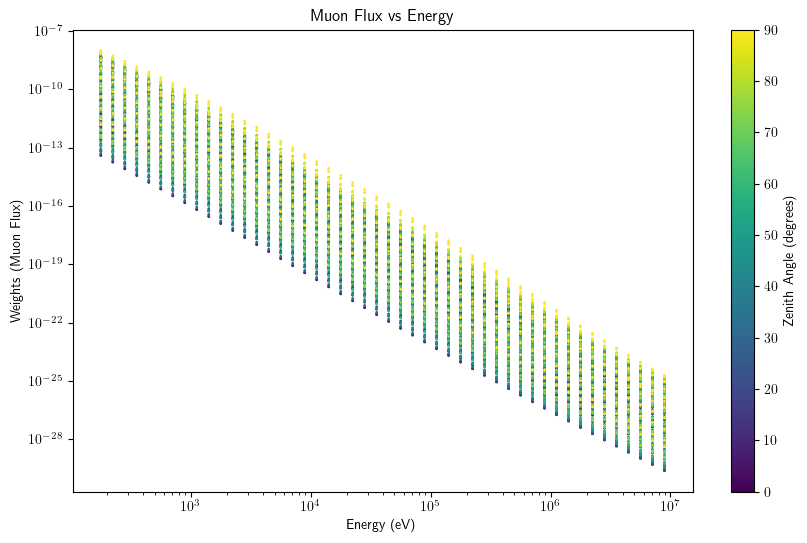

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(energies, weights, c=zeniths, cmap='viridis', s=1)
plt.xlabel("Energy (eV)")
plt.ylabel("Weights (Muon Flux)")
plt.title("Muon Flux vs Energy")
plt.colorbar(label='Zenith Angle (degrees)')
plt.yscale("log")
plt.xscale("log")
plt.show()